In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import shutil
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm

from keras.metrics import mean_squared_error as mse 


tf.config.get_visible_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
IMAGE_WIDTH = 60
IMAGE_HEIGHT = 70

In [ ]:
def cluster_and_arrange_image(img, n_clusters):
    if IMAGE_HEIGHT * IMAGE_WIDTH % n_clusters != 0:
        raise Exception("Wrong number of clusters !!!")
    n_pixels_per_cluster = int(IMAGE_HEIGHT * IMAGE_WIDTH / n_clusters)
    X = img.reshape(-1,3)
    km = KMeans(n_clusters=n_clusters).fit(X)
    means = np.mean(km.cluster_centers_, axis=1)
    sorted_means = np.sort(means)
    idxs = []
    for i in range(n_clusters):
        for j in range(n_clusters):
            if sorted_means[i] == means[j]:
                idxs.append(j)
                break
    segmented_arranged_img = []
    for i in range (n_clusters):
        cluster = X[km.labels_ == idxs[i]]
        if len(cluster) < n_pixels_per_cluster :
            ix = idxs[i]
            for i in range(len(cluster), n_pixels_per_cluster):
                cluster = np.append(cluster, km.cluster_centers_[ix:ix + 1], axis=0)
        else:
            cluster = cluster[:n_pixels_per_cluster]
        segmented_arranged_img.extend(np.uint8(cluster))
    segmented_arranged_img =  np.asarray(segmented_arranged_img)
    segmented_arranged_img = segmented_arranged_img.reshape(img.shape)
    return segmented_arranged_img

In [ ]:
print ("prepare training data:")
X_train_0 = []
X_val_0 = []

path = glob.glob("clean-normal-clustered-3/train/*.jpg")

for i, file in enumerate(tqdm(path)):
    clustered_image = plt.imread(file)
    clustered_image = clustered_image / 255.
    if i % 5 == 0:
        X_val_0.append(clustered_image)
    else:
        X_train_0.append(clustered_image)

X_train_0 = np.asarray(X_train_0)
X_val_0 = np.asarray(X_val_0)

print("Train instances: " + str(len(X_train_0)))
print("Val instances: " + str(len(X_val_0)))

prepare training data:


100%|██████████| 59437/59437 [00:20<00:00, 2924.83it/s]


Train instances: 47549
Val instances: 11888


In [ ]:
print("Building Autoencoder:")

encoder = keras.models.Sequential(name= "encoder", layers= [
  keras.layers.Flatten(input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3]),
  keras.layers.AlphaDropout(rate=0.2),
  keras.layers.Dense(10000, activation="selu"),
  keras.layers.Dense(6000, activation="selu"),
  keras.layers.Dense(3000, activation="selu"),
  keras.layers.Dense(1000, activation="selu"),
])

decoder = keras.models.Sequential(name= "decoder",layers= [
  keras.layers.Dense(3000, activation="selu", input_shape=[1000]),
  keras.layers.Dense(6000, activation="selu"),
  keras.layers.Dense(10000, activation="selu"),
  keras.layers.Dense(IMAGE_HEIGHT * IMAGE_WIDTH * 3, activation="sigmoid"),
  keras.layers.Reshape([IMAGE_HEIGHT, IMAGE_WIDTH, 3])                                  
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mean_squared_error",
                   optimizer='sgd',
                   metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#checkpoint_cb = keras.callbacks.ModelCheckpoint("models/autoencoder-cleaned-{epoch:02d}-{val_accuracy:.2f}.hdf5",  monitor='val_accuracy', save_best_only=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("drive/MyDrive/models/temp/autoencoder-{epoch:02d}-{val_accuracy:.2f}.hdf5",  monitor='val_accuracy', save_best_only=True, save_freq='epoch', period=5)

history = autoencoder.fit(X_train_0, X_train_0, epochs=100, validation_data=(X_val_0, X_val_0), callbacks=[early_stopping_cb, checkpoint_cb])

Building Autoencoder:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12600)             0         
                                                                 
 alpha_dropout (AlphaDropout  (None, 12600)            0         
 )                                                               
                                                                 
 dense (Dense)               (None, 10000)             126010000 
                                                                 
 dense_1 (Dense)             (None, 6000)              60006000  
                                                                 
 dense_2 (Dense)             (None, 3000)              18003000  
                                                                 
 dense_3 (Dense)             (None, 1000)              3001000   
                                     

In [5]:
autoencoder = keras.models.load_model("models/autoencoder-clean-20-0.93.hdf5")

In [67]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 1000)              207020000 
                                                                 
 decoder (Sequential)        (None, 70, 60, 3)         207031600 
                                                                 
Total params: 414,051,600
Trainable params: 414,051,600
Non-trainable params: 0
_________________________________________________________________


In [45]:
path = glob.glob("clean-normal-clustered-3/test/*.jpg")

X_test_0 = []
for file in tqdm(path):
    img = plt.imread(file)
    img = img / 255.
    X_test_0.append(img)

X_test_0 = np.asarray(X_test_0)
print("Test: " + str(len(X_test_0)))

100%|██████████| 13907/13907 [00:03<00:00, 3942.41it/s]


Test: 13907


In [46]:
y_pred = autoencoder.predict(X_test_0)

In [47]:
error = mse(y_pred, X_test_0)
err_mean = np.mean(error, axis = 1)
err_mean = np.mean(err_mean, axis = 1)
print(np.shape(y_pred))
print(np.shape(error))
print(np.shape(err_mean))
print(len(err_mean[ err_mean > 0.05]))

(13907, 70, 60, 3)
(13907, 70, 60)
(13907,)
347


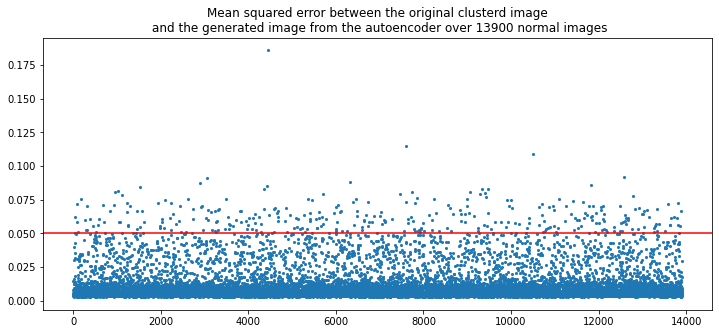

In [49]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(err_mean))
y = err_mean
ax.set_title("Mean squared error between the original clusterd image\n and the generated image from the autoencoder over 13900 normal images")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.05, color = 'r', linestyle = '-')
plt.show()

In [57]:
path = glob.glob("clustered-3/train/1/*.jpg")
X_test_1 = []
for file in tqdm(path):
  img = plt.imread(file)
  img = img / 255.
  X_test_1.append(img)
X_test_1 = np.asarray(X_test_1)
print("Test_1: " + str(len(X_test_1)))

100%|██████████| 4953/4953 [00:01<00:00, 3803.09it/s]


Test_1: 4953


In [58]:
y_pred_fail = autoencoder.predict(X_test_1)

In [59]:
error_fail = mse(y_pred_fail, X_test_1)
err_mean_fail = np.mean(error_fail, axis = 1)
err_mean_fail = np.mean(err_mean_fail, axis = 1)
print(np.shape(y_pred_fail))
print(np.shape(error_fail))
print(np.shape(err_mean_fail))
print(len(err_mean_fail[ err_mean_fail < 0.05]))

(4953, 70, 60, 3)
(4953, 70, 60)
(4953,)
1652


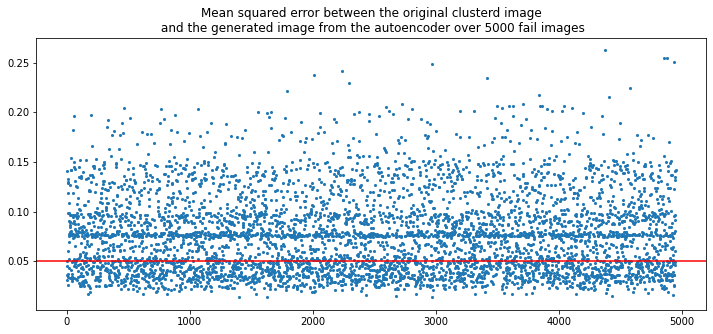

In [61]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(err_mean_fail))
y = err_mean_fail
ax.set_title("Mean squared error between the original clusterd image\n and the generated image from the autoencoder over 5000 fail images")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.05, color = 'r', linestyle = '-')
plt.show()

## <br>
## Let's try to inspect the first cluster of images:

In [62]:
y_pred_first = y_pred[:, :20, :, :]
X_test_0_first = X_test_0[:, :20, :, :]
error = mse(y_pred_first, X_test_0_first)
err_mean = np.mean(error, axis = 1)
err_mean = np.mean(err_mean, axis = 1)
print(np.shape(y_pred))
print(np.shape(error))
print(np.shape(err_mean))
print(len(err_mean[ err_mean > 0.05]))

(13907, 70, 60, 3)
(13907, 20, 60)
(13907,)
449


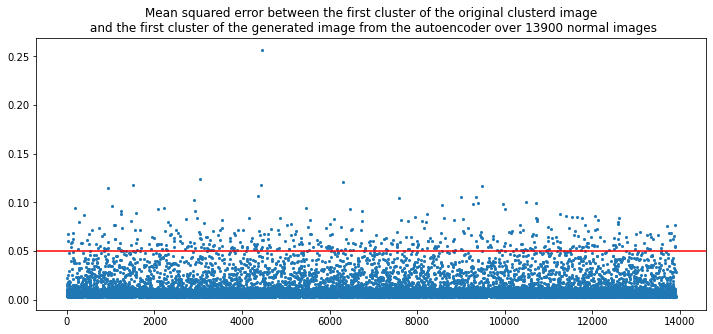

In [63]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(err_mean))
y = err_mean
ax.set_title("Mean squared error between the first cluster of the original clusterd image\n and the first cluster of the generated image from the autoencoder over 13900 normal images")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.05, color = 'r', linestyle = '-')
plt.show()

In [64]:
y_pred_fail_first = y_pred_fail[: , :20 , :, :]
X_test_1_first = X_test_1[: , :20 , :, :]
error_fail = mse(y_pred_fail_first, X_test_1_first)
err_mean_fail = np.mean(error_fail, axis = 1)
err_mean_fail = np.mean(err_mean_fail, axis = 1)
print(np.shape(y_pred_fail))
print(np.shape(error_fail))
print(np.shape(err_mean_fail))
print(len(err_mean_fail[ err_mean_fail < 0.05]))

(4953, 70, 60, 3)
(4953, 20, 60)
(4953,)
71


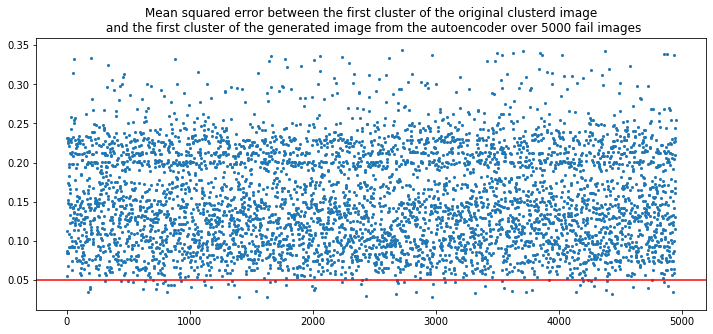

In [66]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(err_mean_fail))
y = err_mean_fail
ax.set_title("Mean squared error between the first cluster of the original clusterd image\n and the first cluster of the generated image from the autoencoder over 5000 fail images")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.05, color = 'r', linestyle = '-')
plt.show()